In [179]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
# import athena_read
import athena_read_select
import h5py
import netCDF4
import xarray as xr

In [180]:
filename = 'test-disk.out1.00000.athdf'

In [181]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [182]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 24 24]
0
2772
[5]
[168  72 576]
[0.4      2.5      1.003814]
[1.3962634 1.7453293 1.       ]
[0.        6.2831855 1.       ]
0.0
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [183]:
data['rho'].shape

(588, 1152, 560)

In [49]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()
phipos=400

In [184]:
r = data['x1v']
theta = data['x2v']
phi = data['x3v']

In [185]:
rp, thetap, phip = 1, np.pi / 2, np.pi

In [186]:
rho = data['rho']

In [187]:
# making r, theta, and phi 3D arrays
r = r[np.newaxis, np.newaxis, :]
theta = theta[np.newaxis, :, np.newaxis]
phi = phi[:, np.newaxis, np.newaxis]

In [188]:
theta.shape

(1, 1152, 1)

In [189]:
x = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.cos(data['x3v'][:,np.newaxis, np.newaxis])
y = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis])
z = data['x1v'][np.newaxis, np.newaxis,:] * np.cos(data['x2v'][np.newaxis, :, np.newaxis])

In [190]:
z.shape

(1, 1152, 560)

In [191]:
x.shape

(588, 1152, 560)

In [192]:
x_test = np.linspace(0,10,100)
y_test = np.linspace(0,10,100)
z_test = np.linspace(0,10,100)

In [193]:
cart_coords_test = np.stack(np.meshgrid(x_test,y_test,z_test, indexing='ij'), axis=-1)

In [194]:
cart_coords_test.shape

(100, 100, 100, 3)

In [195]:
(cart_coords_test-[2,3,4]).shape

(100, 100, 100, 3)

In [196]:
dist = np.linalg.norm(cart_coords_test-(2,3,4), axis=-1) - 1

In [197]:
dist.shape

(100, 100, 100)

In [198]:
np.unravel_index(np.argmin(dist), dist.shape)

(20, 30, 40)

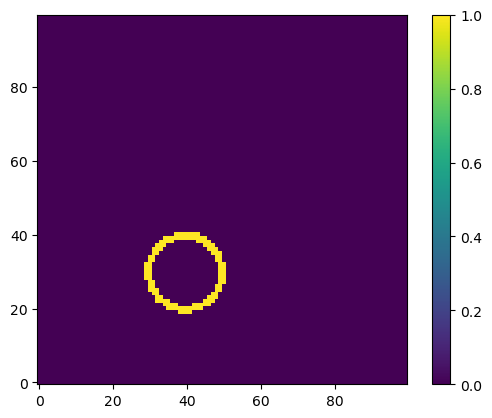

In [199]:
plt.imshow(np.abs(dist[20])<0.1, origin='lower')
plt.colorbar()

In [200]:
# recentering the coordinates to make the planet-centered
r_new = np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi))
phi_new = np.arctan2(r * np.sin(theta) * np.sin(phi), r * np.sin(theta) * np.cos(phi) + rp)
theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_3890/1201654965.py:4: RuntimeWarning: invalid value encountered in arccos
  theta_new = np.arccos(r * np.cos(theta) / np.sqrt(r ** 2 + rp ** 2 + 2 * r * rp * np.sin(theta) * np.cos(phi)))


In [201]:
dist = np.sqrt((x + 1) ** 2 + y ** 2 + z ** 2) - Rh

In [202]:
np.unravel_index(np.argmin(dist), dist.shape)

(293, 576, 194)

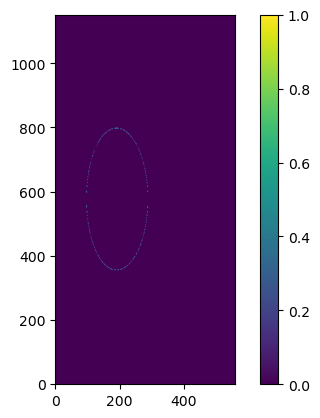

In [203]:
plt.imshow(np.abs(dist[293])<0.0001, origin='lower')
plt.colorbar()

In [204]:
indices = np.nonzero((np.abs(dist)<3e-4) & (~np.isnan(theta_new)))

In [205]:
indices

(array([195, 195, 195, ..., 392, 392, 392]),
 array([562, 562, 562, ..., 589, 589, 589]),
 array([189, 190, 191, ..., 190, 191, 192]))

In [206]:
theta.shape

(1, 1152, 1)

In [207]:
lon = np.pi - phi_new[indices] % (2*np.pi)
lat = np.pi/2 - theta_new[indices] % np.pi

In [208]:
rho[indices[0],indices[1],indices[2]]

array([0.9995878 , 0.9995878 , 0.99842685, ..., 0.9995878 , 0.99842685,
       0.99842685], dtype=float32)

In [209]:
r.shape

(1, 1, 560)

In [210]:
lat.shape

(234025,)

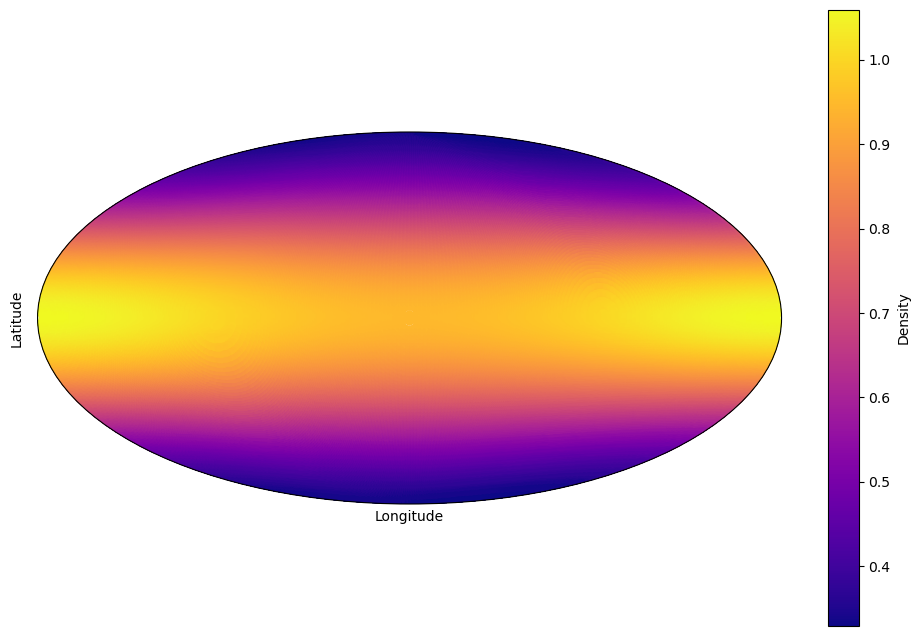

In [211]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.scatter(lon, lat, c=rho[indices], s=10, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Density')
plt.show()

In [111]:
rho[indices].shape

(234027,)

In [215]:
def init_den(r, theta=np.pi/2, beta=3/2, gamma=1.4, c=0.05):
    R = r * np.sin(theta)
    return 1. * (r ** (-(beta+3/2) * (2 * (gamma-1)/(gamma+1))) - 1. * (gamma - 1) / c ** 2 * (1/R - 1/r)) ** (1/(gamma-1))
    # return 1. * (r/rp)**(-3/2) * np.exp(1. / (c**2) * (1./np.sqrt(np.sqrt(r)+np.sqrt(R)) - 1./r));

In [216]:
init_den(data['x1v'])

array([1.4284616 , 1.4257095 , 1.422964  , 1.4202253 , 1.4174937 ,
       1.414769  , 1.4120508 , 1.409339  , 1.406634  , 1.4039353 ,
       1.4012431 , 1.3985584 , 1.3958803 , 1.3932079 , 1.3905423 ,
       1.3878833 , 1.3852302 , 1.3825839 , 1.3799444 , 1.3773117 ,
       1.3746849 , 1.3720644 , 1.3694503 , 1.3668422 , 1.3642403 ,
       1.3616457 , 1.3590572 , 1.3564746 , 1.3538982 , 1.3513281 ,
       1.3487641 , 1.346206  , 1.3436551 , 1.3411093 , 1.3385702 ,
       1.3360373 , 1.3335102 , 1.3309892 , 1.3284749 , 1.3259658 ,
       1.3234626 , 1.3209662 , 1.3184756 , 1.3159908 , 1.3135123 ,
       1.3110399 , 1.308573  , 1.3061117 , 1.3036567 , 1.3012077 ,
       1.2987645 , 1.2963268 , 1.293895  , 1.2914687 , 1.2890487 ,
       1.2866341 , 1.2842257 , 1.2818232 , 1.279426  , 1.2770344 ,
       1.2746491 , 1.2722691 , 1.2698941 , 1.2675256 , 1.2651627 ,
       1.2628049 , 1.2604529 , 1.2581065 , 1.2557654 , 1.2534305 ,
       1.2511013 , 1.2487769 , 1.2464579 , 1.2441449 , 1.24183

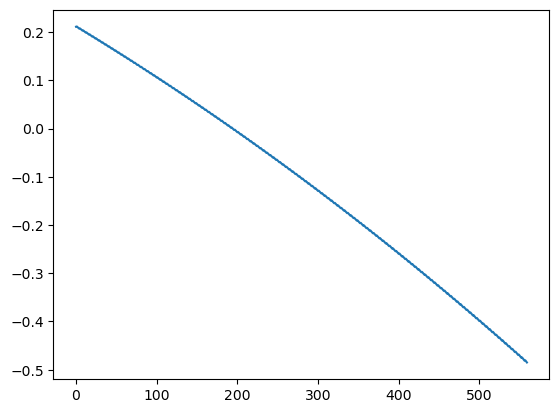

In [227]:
plt.plot((init_den(data['x1v']) - data['rho'][0,thetapos,:])/init_den(data['x1v']))

In [80]:
# # define the number of points on the surface of the sphere
# N = len(rho[indices])

# # density = rho[indices].reshape(N,N)

# # create an array to store the azimuthally averaged density values
# azavg_density = np.zeros(N)

# # define the bin width for the azimuthal angle
# bin_width = np.deg2rad(1)

# # loop over the points on the surface of the sphere and accumulate the density values in each bin

# # compute the number of points in each bin
# num_points = np.zeros(N)

# for i in range(N):
#     bin_index = int(phi_new[indices][i] / bin_width)
#     azavg_density[bin_index] += rho[indices][i]

#     phi_bin_min = i*bin_width
#     phi_bin_max = (i+1)*bin_width
#     phi_indices = np.where((phi_new[indices] >= phi_bin_min) & (phi_new[indices] < phi_bin_max))
#     num_points[i] = len(phi_indices[0])

#     if num_points[i] > 0:
#         azavg_density[i] /= num_points[i]

In [81]:
# # plot the azimuthally averaged density using pcolormesh
# fig, ax = plt.subplots()
# mesh = ax.pcolormesh(phi_new[indices], r_new[indices], azavg_density[np.newaxis, :], shading='auto')
# fig.colorbar(mesh, ax=ax)
# ax.set_xlabel('Azimuthal angle (phi)')
# ax.set_ylabel('Radial distance (r)')
# plt.show()

In [82]:
# # compute the radial coordinate values
# r_plot = np.outer(np.ones(N), r_new[indices])

# # plot the azimuthally averaged density using pcolormesh
# fig, ax = plt.subplots()
# mesh = ax.pcolormesh(phi_new, r_plot[:, 0], azavg_density[np.newaxis, :], shading='auto')
# fig.colorbar(mesh, ax=ax)
# ax.set_xlabel('Azimuthal angle (phi)')
# ax.set_ylabel('Radial distance (r)')
# plt.show()

In [118]:
# bins = np.arange(0,np.pi)
bins = np.linspace(0,np.pi, 1000)
bin_indices = np.digitize(theta_new[indices], bins, right=True)

average_data = np.zeros_like(bin_indices, dtype=rho.dtype)
for i in range(average_data.shape[0]):
    average_data[i] = rho[indices][bin_indices == i].mean()

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_3890/1632327129.py:7: RuntimeWarning: Mean of empty slice.
  average_data[i] = rho[indices][bin_indices == i].mean()
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [119]:
theta_new[indices]

array([1.5108474, 1.5107965, 1.5107512, ..., 1.6329112, 1.6329582,
       1.6329978], dtype=float32)

In [120]:
average_data

array([       nan,        nan, 0.04506236, ...,        nan,        nan,
              nan], dtype=float32)

In [153]:
np.where(np.isnan(rho[indices]))

(array([], dtype=int64),)

In [177]:
from scipy import stats

average_data = stats.binned_statistic_2d(r_new[indices],theta_new[indices], rho[indices], statistic='mean',bins=100)

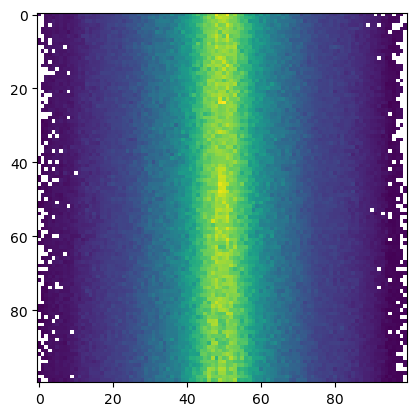

In [178]:
plt.imshow(average_data.statistic, interpolation='nearest')